## Project Overview
Go through the DS pipeline and create a model that will predict whether a customer will stay or churn based off drivers.

## Project Goal
- Find drivers for customer churn at Telco.

- Construct a ML classification model that accurately predicts customer churn.

- The goal is to have a model perform better than the baseline one, and optimize recall.

In [1]:
#Essential import 
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

#Turn off warning 
import warnings
warnings.filterwarnings("ignore")

#Import env file
from env import user_name, password, host

#Import functions from acquire, prepare, explore and model from directory
import acquire
import prepare
import explore
import modeling

#Sklearn to help with machine learning 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

## Acquire Telco_Churn Data

In [2]:
#This will get the function from acquire that is connect to the codeup database
#First it will execute the SQL query, return a dataframe and then create a csv file in directory
df = acquire.get_telco_data()

In [3]:
#Checking the function if working properly and return correct data
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,contract_type_id.1,contract_type,payment_type_id.1,payment_type,internet_service_type_id.1,internet_service_type
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,1,No,Yes,No,Yes,Yes,No,2,Yes,2,65.6,593.3,No,2,One year,2,Mailed check,1,DSL
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,No,No,No,No,No,Yes,1,No,2,59.9,542.4,No,1,Month-to-month,2,Mailed check,1,DSL
2,0004-TLHLJ,Male,0,No,No,4,Yes,No,2,No,No,Yes,No,No,No,1,Yes,1,73.9,280.85,Yes,1,Month-to-month,1,Electronic check,2,Fiber optic
3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,2,No,Yes,Yes,No,Yes,Yes,1,Yes,1,98.0,1237.85,Yes,1,Month-to-month,1,Electronic check,2,Fiber optic
4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,2,No,No,No,Yes,Yes,No,1,Yes,2,83.9,267.4,Yes,1,Month-to-month,2,Mailed check,2,Fiber optic


In [4]:
#Want to see the data type of each columns and how many rows and columns in the telco dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customer_id                 7043 non-null   object 
 1   gender                      7043 non-null   object 
 2   senior_citizen              7043 non-null   int64  
 3   partner                     7043 non-null   object 
 4   dependents                  7043 non-null   object 
 5   tenure                      7043 non-null   int64  
 6   phone_service               7043 non-null   object 
 7   multiple_lines              7043 non-null   object 
 8   internet_service_type_id    7043 non-null   int64  
 9   online_security             7043 non-null   object 
 10  online_backup               7043 non-null   object 
 11  device_protection           7043 non-null   object 
 12  tech_support                7043 non-null   object 
 13  streaming_tv                7043 

## Prepare Telco_Churn Data

In [5]:
df = prepare.clean_data(df)

In [6]:
train, validate, test = prepare.split_data(df)

In [7]:
print('train shape    :',train.shape)
print('validate shape :',validate.shape)
print('test shape     :',test.shape)

train shape    : (3943, 28)
validate shape : (1691, 28)
test shape     : (1409, 28)


## Data Exploration

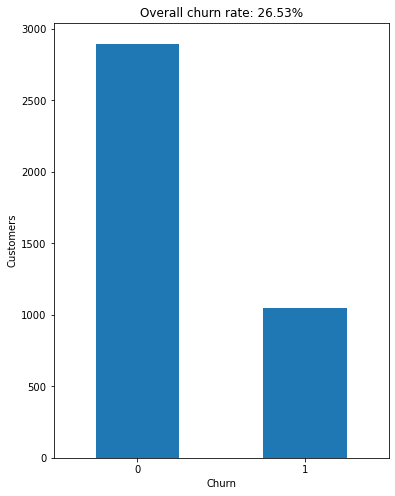

In [8]:
#Calculate the overall churn rate and create a bar plot 
#Over churn rate is..
explore.churn_bar(train)

<AxesSubplot:title={'center':'Feautures Correlating with Churn'}>

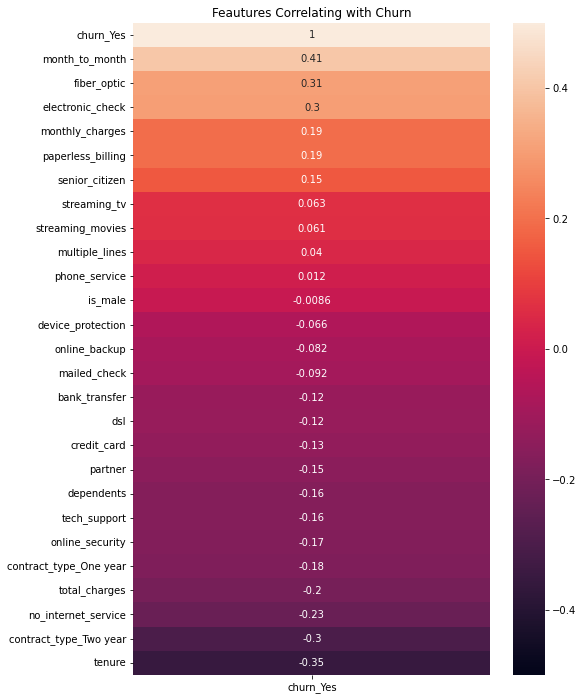

In [9]:
#Heatmap will tell us each feature is releated to churn
explore.get_churn_heatmap(df)

#### Observation:
- Positive correlation are the top of heatmap:
  - Month to month( .41)
  - Fiber optic (.31)
  - Elctronic check (.30)
  - Paperless billing (.19)
<br>
- Negative correlation are the bottom of heatmap:
   - No internet service (-.23)
   - Two years contract (-.30)
   - Tenure (-.35)

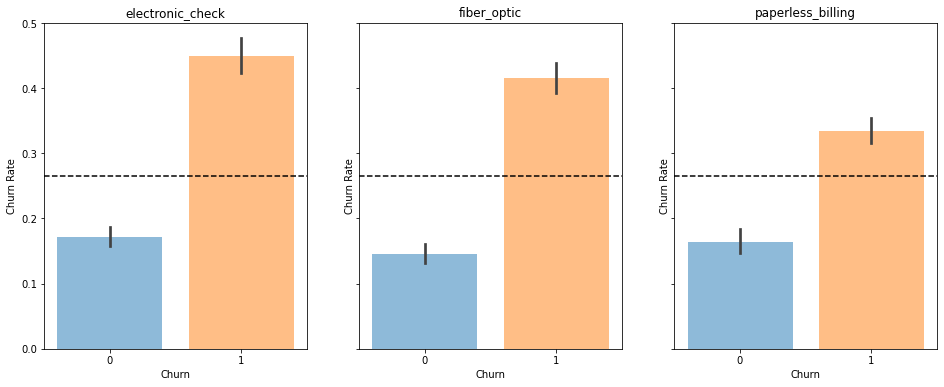

In [10]:
#We plot features have high correlation with churn
features = ['electronic_check','fiber_optic','paperless_billing']
explore.bar_plot(features, train)

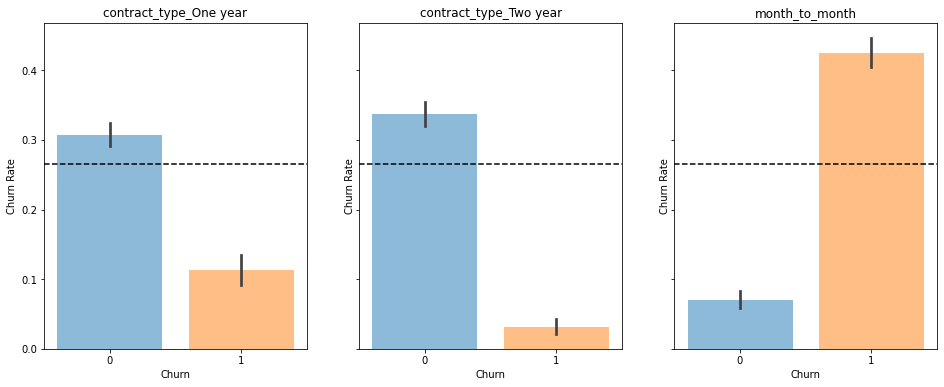

In [11]:
#Same as above
features = ['contract_type_One year','contract_type_Two year','month_to_month']
explore.bar_plot(features, train)

#### Take away:
- For those who churn, most come from the month to month contract
- Electronic check and paperless billing customers ttend to comprise for half of the churn in all payment type
- Customers who use fiber optic churn more frequently than those with dsl

In [12]:
#Checking the first month of tenure since it has the high churn rate
explore.report_tenure(train, 1)


** FIRST 1 MONTHS OF TENURE AND CHURN** 

Total customer in the first month: 341
Total customer cancellations in the first month: 212

Churn rate in the first month of Tenure: 62.17%
Paperless_billing:                       66.51%
Electronic_check payment type :          57.08% 
Fiber_optic:                             53.30%

Overall Churn Rate: 26.53%


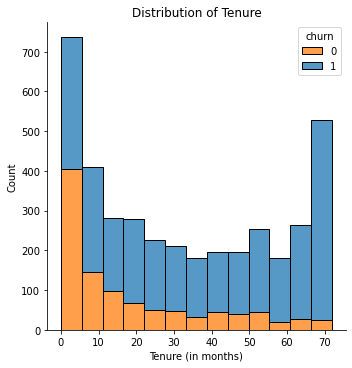

In [13]:
#We select driver(tenure)
explore.plot_tenure(train,'tenure')

#### Take away: 
- Most customers who churn have first month of tenure and it gradually decrease as cutomer have logner tenure
- Churn is 62.17% in the first month of tenure. And all the cancellation in the first month are month to month contract: 66.51% paperless_billing, 57.08% electronic_check, and 53.08% fiber_optic

## Performance Statistic Test

#### Month to month contracts

$H_o$: Monthly Contract and churn are independent of each other

$H_a$: Monthly Contract and churn are not independent of each other

In [14]:
#Set the significane level at 0.05
#Monthly contracts: categorical
#Churn: categorical
#Chi square (categorial vs categorical
α = 0.05
observed = pd.crosstab(train.month_to_month, train.churn_Yes)
observed

churn_Yes,0,1
month_to_month,,
0,1648,125
1,1249,921


In [15]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p, expected[1,1]

(5.32454352599958e-138, 575.6581283286837)

In [16]:
#Compare p value and alpha to see if we fail or reject our hypothesis 
if p < α:
    print('We reject the null Hypothesis')
else:
    print("we fail to reject the null")

We reject the null Hypothesis


#### Take away: 
+ Month to month and churn were dependent, we would expect 575 customer churn, however it is acutally 921 
+ Customers more likely to leave if they were in month to month contract since they are not in long term contract

#### Tenure

$H_o$: There is no difference in churn rate between customer with 1 month of tenure and the customers with longer tenure

$H_a$: There is a difference in churn rate between customer with 1 month of tenure and the customers with longer tenure

In [17]:
#Set the significane level at 0.05
#Tenure: Continous
#Churn: categorical
#One Sample T-test (categorial vs continous), 2-tailed test
α = 0.05
t, p = stats.ttest_1samp(train.tenure, train.churn_Yes.mean())
t,p

(82.37669227970096, 0.0)

In [18]:
#Compare p value and alpha to see if we fail or reject our hypothesis 
if p < α:
    print('We reject the null Hypothesis')
else:
    print("we fail to reject the null")

We reject the null Hypothesis


#### Paperless-billing

$H_o$: Paperless-billing and churn are independent of each other

$H_a$: Paperless-billing and churn are not independent of each other

In [19]:
#Set the significane level at 0.05
#Paperless-billing: categorical
#Churn: categorical
#Chi square (categorial vs categorical
α = 0.05
observed = pd.crosstab(train.paperless_billing, train.churn_Yes)
observed

churn_Yes,0,1
paperless_billing,,
0,1335,263
1,1562,783


In [20]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p, expected[1,1]

(4.5700436817719314e-32, 622.0821709358356)

In [21]:
#Compare p value and alpha to see if we fail or reject our hypothesis 
if p < α:
    print('We reject the null Hypothesis')
else:
    print("we fail to reject the null")

We reject the null Hypothesis


#### Take away:
+ Paperless billing and churn were dependent, we would expect 622 customer churn, however it is acutally 782
+ Customer maybe have some inconvenient process  

#### Electronic check

$H_o$: Customer paying with e-checks and churn are independent of each other

$H_a$: Customer paying with e-checks and churn are dependent of each other.

In [22]:
#Set the significane level at 0.05
#Electronic check: categorical
#Churn: categorical
#Chi square (categorial vs categorical
α = 0.05
observed = pd.crosstab(train.electronic_check, train.churn_Yes)
observed

churn_Yes,0,1
electronic_check,,
0,2166,449
1,731,597


In [23]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p, expected[1,1]

(1.5484237807491145e-77, 352.29216332741566)

In [24]:
#Compare p value and alpha to see if we fail or reject our hypothesis 
if p < α:
    print('We reject the null Hypothesis')
else:
    print("we fail to reject the null")

We reject the null Hypothesis


#### Take away:
+ Electronic check and churn were dependent, we would expect 352 customer churn, however it is acutally 597

#### Fiber_optic

$H_o$: Customer paying with fiber optic and churn are independent of each other

$H_a$: Customer paying with fiber optic and churn are dependent of each other.

In [25]:
#Set the significane level at 0.05
#Electronic check: categorical
#Churn: categorical
#Chi square (categorial vs categorical
α = 0.05
observed = pd.crosstab(train.fiber_optic, train.churn_Yes)
observed

churn_Yes,0,1
fiber_optic,,
0,1878,320
1,1019,726


In [26]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p,expected[1,1]

(4.447993420103704e-81, 462.91402485417194)

In [27]:
#Compare p value and alpha to see if we fail or reject our hypothesis 
if p < α:
    print('We reject the null Hypothesis')
else:
    print("we fail to reject the null")

We reject the null Hypothesis


#### Take away:
+ Fiber optic and churn were dependent, we would expect 462 customer churn, however it is acutally 726
+ If customers have fiber optic more likely to churn than dsl

### Modeling

I am trying to predict the customers that will churn. The positive variable will be churn(1) in my following models.

Possible Outcomes:

+ TP: Predict churn and it is churn
+ TN: Predict no churn and it is no churn
+ FP: Predict churn but it is no churn
+ FN: Predict no churn but it is churn

In [28]:
#x_cols are the features I'm focusing on to predict whether a customer churns or not. 
#y_col is our target
x_col = ['fiber_optic', 'electronic_check','tenure', 'paperless_billing', 'month_to_month']
y_col = 'churn_Yes'

In [29]:
#Splitting the data based on features above
X_train, y_train = train[x_col], train[y_col]

X_validate, y_validate = validate[x_col], validate[y_col]

X_test, y_test = test[x_col], test[y_col]

In [30]:
# Baseline prediction is the most frequent value of churn
# No churn(0)
#Create the object
baseline = DummyClassifier(strategy = 'constant', constant = 0)
#Fit the object
baseline.fit(X_train, y_train)
print(f'The baseline accuracy for No Churn in all cases on the telco Dataset is {baseline.score(X_train, y_train):.2%}')

The baseline accuracy for No Churn in all cases on the telco Dataset is 73.47%


### Model 1: Decision Tree

In [31]:
# create the model
d_tree= DecisionTreeClassifier(max_depth=3)
# fit the model
d_tree.fit(X_train, y_train)
# make a prediction for for churn
y_pred = d_tree.predict(X_train)
# look at the model scores for training set and validate set
print(f'training score: {d_tree.score(X_train, y_train):.2%}')
print(f'validate score: {d_tree.score(X_validate, y_validate):.2%}')

training score: 78.85%
validate score: 79.07%


In [32]:
#Classification report function from modeling
modeling.get_metrics_binary(X_train, y_train, y_pred, d_tree)


    The accuracy for our model is 78.849%
    The True Positive Rate is 37.667%, The False Positive Rate is 6.282%,
    The True Negative Rate is 93.718%, and the False Negative Rate is 62.333%
    


,precision,recall,f1-score,support
0,0.806356,0.937176,0.866858,2897.000000
1,0.684028,0.376673,0.485820,1046.000000
accuracy,0.788486,0.788486,0.788486,0.788486
macro avg,0.745192,0.656925,0.676339,3943.000000
weighted avg,0.773905,0.788486,0.765776,3943.000000


### Model 2: Random Forest

In [33]:
# create the Random Forest Model
r_forest = RandomForestClassifier(min_samples_leaf=4, max_depth=4, random_state=1349)
# fit the object
r_forest.fit(X_train, y_train)
# make a prediction for for churn
y_pred = r_forest.predict(X_train)
# look at the model scores for training set and validate set
print(f'training score: {r_forest.score(X_train, y_train):.2%}')
print(f'validate score: {r_forest.score(X_validate, y_validate):.2%}')

training score: 79.61%
validate score: 79.95%


In [34]:
modeling.get_metrics_binary(X_train, y_train, y_pred, r_forest)


    The accuracy for our model is 79.609%
    The True Positive Rate is 43.595%, The False Positive Rate is 7.387%,
    The True Negative Rate is 92.613%, and the False Negative Rate is 56.405%
    


,precision,recall,f1-score,support
0,0.819737,0.926130,0.869692,2897.000000
1,0.680597,0.435946,0.531469,1046.000000
accuracy,0.796094,0.796094,0.796094,0.796094
macro avg,0.750167,0.681038,0.700580,3943.000000
weighted avg,0.782826,0.796094,0.779968,3943.000000


### Model 3: KNN

In [35]:
#create the object
knn = KNeighborsClassifier(n_neighbors=5)
#fit the object
knn.fit(X_train, y_train)
y_pred = knn.predict(X_train)
print(f'training score: {knn.score(X_train, y_train):.2%}')
print(f'validate score: {knn.score(X_validate, y_validate):.2%}')

training score: 81.13%
validate score: 76.46%


In [36]:
modeling.get_metrics_binary(X_train, y_train, y_pred, knn)


    The accuracy for our model is 81.131%
    The True Positive Rate is 58.700%, The False Positive Rate is 10.770%,
    The True Negative Rate is 89.230%, and the False Negative Rate is 41.300%
    


,precision,recall,f1-score,support
0,0.856811,0.892302,0.874197,2897.000000
1,0.663067,0.586998,0.622718,1046.000000
accuracy,0.811311,0.811311,0.811311,0.811311
macro avg,0.759939,0.739650,0.748457,3943.000000
weighted avg,0.805415,0.811311,0.807484,3943.000000


### Model 4: Logistic Regression

In [37]:
#Create the object
logit = LogisticRegression(C= 1.0, random_state =123)
#Fit the object
logit.fit(X_train, y_train)
# make a prediction for for churn
y_pred = logit.predict(X_train)
print(f'training score: {logit.score(X_train, y_train):.2%}')
print(f'validate score: {logit.score(X_validate, y_validate):.2%}')

training score: 79.25%
validate score: 78.59%


In [38]:
modeling.get_metrics_binary(X_train, y_train, y_pred, logit)


    The accuracy for our model is 79.254%
    The True Positive Rate is 47.610%, The False Positive Rate is 9.320%,
    The True Negative Rate is 90.680%, and the False Negative Rate is 52.390%
    


,precision,recall,f1-score,support
0,0.827402,0.906800,0.865283,2897.000000
1,0.648438,0.476099,0.549063,1046.000000
accuracy,0.792544,0.792544,0.792544,0.792544
macro avg,0.737920,0.691450,0.707173,3943.000000
weighted avg,0.779926,0.792544,0.781396,3943.000000


### Take away:
+ All of the model that created performed better than the baseline accuracy (73.47%). I selected the model that has least drop-off from train to validate
+ The best model is logistic regression

### Test

In [39]:
#the actual results and the predicted results to make a classification report
actual_test = y_test
predicted_test = knn.predict(X_test)
print(classification_report(actual_test, predicted_test))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1035
           1       0.55      0.52      0.54       374

    accuracy                           0.76      1409
   macro avg       0.69      0.68      0.69      1409
weighted avg       0.76      0.76      0.76      1409



In [40]:
#let's see the training, validate, and test score. All better than the baseline of 73.4%
print(f'training score: {knn.score(X_train, y_train):.2%}')
print(f'validate score: {knn.score(X_validate, y_validate):.2%}')
print(f'test score: {knn.score(X_test, y_test):.2%}')

training score: 81.13%
validate score: 76.46%
test score: 76.08%


### Predictions

In [41]:
#Get the probability
proba_test = logit.predict_proba(X_test)

In [42]:
#Put the probability in a data
proba_df = pd.DataFrame(proba_test, columns = ['no_churn','churn_probability'])
proba_df.head()

,no_churn,churn_probability
0,0.868418,0.131582
1,0.982800,0.017200
2,0.346241,0.653759
3,0.395900,0.604100
4,0.256994,0.743006


In [43]:
#Drop a column since we dont need probability that customers is no churn
proba_df.drop(columns= 'no_churn',inplace =True)

In [44]:
proba_df.head()

,churn_probability
0,0.131582
1,0.017200
2,0.653759
3,0.604100
4,0.743006


In [45]:
#Calculate the prediction
predict = logit.predict(X_test)

In [46]:
#Reset the index to concat with the dataframe above(proba_df)
cust_id = test['customer_id'].reset_index()

In [47]:
#Dropping the 'index' column 
cust_id.drop(columns='index', inplace=True)

In [48]:
#Concat the two dataframe together
test_proba_df = pd.concat([cust_id, proba_df], axis=1)
test_proba_df.head()

,customer_id,churn_probability
0,4531-AUZNK,0.131582
1,2296-DKZFP,0.017200
2,9692-TUSXH,0.653759
3,5129-JLPIS,0.604100
4,1273-MTETI,0.743006


In [49]:
#Create a new column in dataframe that we just joined (test_proba_df)
#Add prediction in the new column
test_proba_df['churn_predicted'] = predict

In [50]:
test_proba_df.sample(5)

,customer_id,churn_probability,churn_predicted
873,7909-FIOIY,0.242072,0
853,3992-YWPKO,0.618304,1
33,5886-VLQVU,0.401271,0
1088,6080-LNESI,0.026098,0
421,3648-GZPHF,0.073310,0


In [51]:
#To csv file
test_proba_df.to_csv('telco_predictions.csv')

### Summary:

#### Key Takeaway:

Best Feature to predict churn are:
- Month to month contract
- Fiber optic
- Electronic check 
- Paperless billing 
- Tenure

I choose logistic regression as my best model, because it has 79% accuracy and it wasnt overfit

#### Recommendation: 

+ Look into fiber optic program 
+ Make a better impression to month to month contract customers

#### Next Step:

+ Adjust the hyperparameters, add more features 
+ Check why customer with fiber optic are canceled more than dsl
+ Conduct a research for the recommendations